In [1]:
import itertools
import json
import warnings
warnings.filterwarnings("ignore")

from util import *
from scipy.sparse import vstack, csr_matrix, coo_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import load_model
from sklearn.utils import class_weight
from keras.layers import *
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger

Using TensorFlow backend.


# Corpora for training model

In [2]:
sources = {'art': [60114472, 19191317], 
           'politics': [29534144, 23482909], 
           'finances': [62438886, 81354264],
           'strateg_management': ["http://www.stplan.ru/", "http://www.30n.ru/2/1.html"], 
           'law': [65974416, 79084019],
           'elaboration': ["https://vk.com/"], 
           'industry': [67183197, 66233468], 
           'education': [30558759, 98643656],
#            'social_business': [23509868, 56821139],
           'charity': [],
           'public_health': [78860407, 61490488],
           'agriculture': ["http://www.nsh.ru/", "http://россельхоз.рф/"],
           'government_management': ["http://be5.biz/upravlenie/gosudarstvennoe_upravlenie.html", 97296142],
           'smm': [74686342, 79925455],
           'innovations': [98643656, 63337812],
           'safety': [37959220, 10933209],
           'military': ["http://www.soldiering.ru", "https://voennoe-delo.com"],
           'corporative_management': ["http://www.cfin.ru/management/"],
           'social_safety': [49582956, 72388807],
           'building': [30713157, 26978036],
           'entrepreneurship': [69560028, 73537456],
           'sport': [29809500, 128350290],
           'investitions': [37876217, 3800580]
          }

In [3]:
# getting data for corpora
for tag, ids_ in sources.items():
    path = f"assets/corpora/{tag}.txt"
    s = set()
    if not os.path.exists(path):
        with open(path, "w") as f:
            for id_ in ids_:
                if isinstance(id_, int):
                    wall = ParseClass.getallwall({"owner_id": -id_}, 1000)
                    for post in tqdm.tqdm(wall):
                        if len(post) and post not in s:
                            s.add(post)
                            _ = f.write(f"{post}\n")
                elif isinstance(id_, str):
                    links = np.random.choice(list(ParseClass.get_all_links(id_)), 1000)
                    for link in tqdm.tqdm(links):
                        try:
                            page = requests.get(link).text
                            soup = BeautifulSoup(page, "lxml")
                            for text in soup.text.strip().split("\n"):
                                if len(text) and text not in s:
                                    s.add(text)
                                    _ = f.write(f"{text}\n")
                        except: pass

Manual processing

In [4]:
categories = list(sources.keys())

# Making model

In [5]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# order of labels in `target_names` can be different from `categories`
target_names = categories

In [6]:
corpora_class = CorporaClass()

for filename in categories:
    with open(f"assets/corpora/{filename}.txt") as f:
        corpora_class.add_to_corpora(f)
# corpora_class.process_corpora()

# json.dump(list(corpora_class.vocab), open("assets/vocab.json", "w"))
pickle.dump(corpora_class.corpora, open("assets/corpora.p", "wb"))

In [7]:
corpora = pickle.load(open("assets/corpora.p", "rb"))
vocab = json.load(open("assets/vocab.json"))

In [8]:
corpora_lengths = []
for i, x in enumerate(corpora):
    corpora_lengths.append(len(x))

In [14]:
vectorizer = TfidfVectorizer(tokenizer=corpora_class.full_process, max_df=0.5, sublinear_tf=True)
docterm_matrix = vectorizer.fit_transform(list(itertools.chain(*(doc for doc in corpora))))

pickle.dump(docterm_matrix, open("assets/docterm_matrix.p", "wb"))
pickle.dump(vectorizer, open("assets/vectorizer.p", "wb"))

In [17]:
docterm_matrix = pickle.load(open("assets/docterm_matrix.p", 'rb'))

In [18]:
DELIM = 1300
NUM_OF_CLASSES = 22
vector_size = docterm_matrix[0].shape[1]

In [74]:
X = csr_matrix(np.empty(docterm_matrix.shape), dtype='float32')
y = csr_matrix(np.empty((docterm_matrix.shape[0], 1)))

ind_arr = np.cumsum(np.array(corpora_lengths))
for c, item in enumerate(docterm_matrix):
    # get index with needed elements
    i = np.where(ind_arr > c)[0][0]
    num = min(item.shape[0], DELIM)
#     for _ in range(num):
#         y_ = np.zeros(NUM_OF_CLASSES)
#         y_[i] = 1
#     y[c] = y_
    y[c] = i
    X[c] = item[:num]

In [75]:
X = X.toarray()
y = y.toarray()

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
%matplotlib inline

In [78]:
feature_names = vectorizer.get_feature_names()

# Extracting 200 best features by a chi-squared test"
ch2 = SelectKBest(chi2, k=5000)
X_train = ch2.fit_transform(X_train, y_train)
X_test = ch2.transform(X_test)
if feature_names:
    # keep selected feature names
    feature_names = [feature_names[i] for i
                     in ch2.get_support(indices=True)]
if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.f1_score(y_test, pred, average='weighted')
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    print("classification report:")
    print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [ ]:
results = []
for clf, name in (
#         (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 151.937s
test time:  0.254s
accuracy:   0.657
dimensionality: 5000
density: 0.561136
top 10 keywords per class:
art: открытие шутливый пользователь принцип неабстрактный универсальный челов...
politics: региональный переселенческий донбассгаза гражданство газопровод сро...
finances: неверный страховой сектор обрабатывать формироваться стат специфика...
strateg_management: европа ботаник классный стадия рыночный сопоставимый крит...
law: оштрафовать софт сержант возбудить детектив подсказать официант застройщ...
elaboration: рид секретариат павлюченко пролетарский соисполнитель экспертиза...
industry: экскаватор экспо мартин несырьевой макс беспилотный совещание камаз...
education: вызов телепорта

train time: 15.368s
test time:  807.089s
accuracy:   0.277
classification report:
                        precision    recall  f1-score   support

                   art       0.00      0.00      0.00        52
              politics       0.00      0.00      0.00        60
              finances       0.80      0.06      0.11        68
    strateg_management       0.43      0.04      0.07        75
                   law       0.22      0.33      0.26       378
           elaboration       0.22      0.31      0.26       158
              industry       0.82      0.08      0.15       173
             education       0.50      0.04      0.07       180
               charity       0.19      0.75      0.30       346
         public_health       0.10      0.17      0.13        63
           agriculture       0.79      0.35      0.49       324
 government_management       0.00      0.00      0.00        46
                   smm       0.32      0.62      0.42       726
           innovation

train time: 5.821s
test time:  0.241s
accuracy:   0.701
dimensionality: 5000
density: 1.000000
top 10 keywords per class:
art: принцип повседневный хор шрифт человечный универсальный прозрачность диз...
politics: переселенческий региональный нерабочий гражданство донбассгаза инте...
finances: рисунок обрабатывать дисфункция стат процентный динамика сектор мал...
strateg_management: выдающийся стратегический стадия оклад ориентация организ...
law: убийство юридический преступник судебный официант застройщик инспектор б...
elaboration: рид конкурсный корп соисполнитель киров экспертиза фгбоу предста...
industry: машиностроение беспилотный ао господдержка экскаватор экспо камаз м...
education: наукарфа инфографик всероссийский олимпиада минобрнаука образовани...
charity: нуждающийся милосердие хлеб затмение тонг сбор бархат диагноз малыш ...
public_health: активация эритроцит гингивита острый панкреатит панкреонекроз ...
agriculture: корма арбуз тег кура зерно муравей шиитака растение пог

train time: 4.200s
test time:  0.259s
accuracy:   0.679
dimensionality: 5000
density: 0.121255
top 10 keywords per class:
art: обратимый ритмический цветовой строфа песенный шрифтовой шутливый хор че...
politics: невыплата избиратель переселенец натяжной донбассгаза переселенческ...
finances: разоряться малое равнозначный сектор стат дисфункция малый динамика...
strateg_management: молотковый стадия хмельницкий рыночный ханжина дифференци...
law: сержант инспектор детектив официант застройщик преступник глум убийство ...
elaboration: пниэр шоссе корп рид тематика фгбоу цитирование соисполнитель ка...
industry: волга ао рязанцев мартин флот камаз экспо макс минпромторг мантур
education: минобрнаука вуз олимпиада космонавт математика урфа школьник наука...
charity: ветеринар помощьдеть приют срочныйсбор тонг диагноз бархат малыш зат...
public_health: панкреонекроз антиоксидант мочевой пародонтит радикал поджелуд...
agriculture: продуктивность мотоблок курятник кура косилка муравей погреб

<Container object of 13 artists>

<Container object of 13 artists>

<Container object of 13 artists>

([], <a list of 0 Text yticklabel objects>)

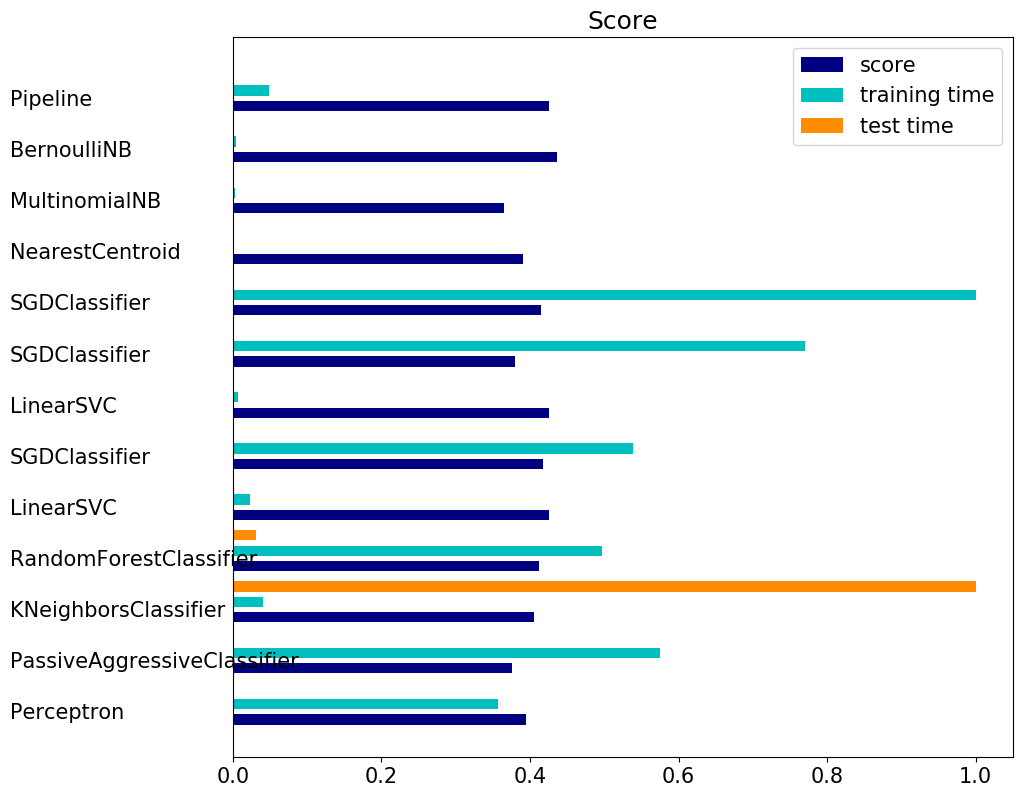

In [58]:
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [62]:
y_train.shape

(17233, 1)

In [72]:
input_vec = Input(shape=(vector_size,))
l1 = Dense(96, activation='relu')(input_vec)
l2 = Dense(18, activation='relu')(l1)
l3 = Dropout(0.15)(l2)
l4 = Dense(64, activation='sigmoid')(l3)
output = Dense(NUM_OF_CLASSES, activation='sigmoid')(l4)

classifier = Model(input_vec, output)
classifier.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [64]:
from sklearn.svm import LinearSVC
svm = LinearSVC(class_weight='balanced')

In [66]:
svm.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [67]:
from sklearn.metrics import f1_score

In [69]:
f1_score(y_test, svm.predict(X_test), average="weighted")

0.41127600160258343

In [73]:
# callbacks = [EarlyStopping(monitor='val_acc',
#                            patience=8,
#                            verbose=1,
#                            min_delta=1e-4,
#                            mode='max'),
#              ReduceLROnPlateau(monitor='val_acc',
#                                factor=0.1,
#                                patience=4,
#                                verbose=1,
#                                epsilon=1e-4,
#                                mode='max'),
#              ModelCheckpoint(monitor='val_acc',
#                              filepath='assets/vk_texts_classifier.h5',
#                              save_best_only=True,
#                              save_weights_only=False,
#                              mode='max'),
#              # TensorBoard(log_dir='logs'),
#              CSVLogger('assets/last_training_log.csv', separator=',', append=False)
#             ]

# classifier.load_weights('vk_texts_classifier.h5')
classifier.fit(X_train, 
               y_train, 
               validation_data=(X_test, y_test), 
               batch_size=196, 
               epochs=75, 
               class_weight='balanced'
#                callbacks=callbacks
              )

Train on 17233 samples, validate on 4309 samples
Epoch 1/75


InvalidArgumentError: Received a label value of 21 which is outside the valid range of [0, 1).  Label values: 4 6 12 19 5 18 12 5 20 12 12 8 19 10 20 12 12 12 17 14 10 12 12 12 20 13 8 13 5 19 4 18 10 20 10 7 19 1 14 19 19 10 8 10 2 8 12 18 19 2 14 1 17 8 17 19 20 12 20 18 12 19 10 18 18 12 4 17 17 5 12 6 6 17 4 12 3 12 19 12 8 18 3 17 19 17 12 12 6 12 20 17 7 10 16 4 4 10 16 17 12 10 10 6 12 19 13 2 12 16 12 13 17 6 15 5 12 10 7 20 7 12 10 0 18 8 17 19 12 5 16 12 20 10 5 8 18 12 9 11 6 4 17 1 1 6 21 18 20 17 4 19 8 17 12 12 12 20 5 12 12 3 12 1 7 8 19 20 1 12 6 19 21 3 18 12 10 19 13 8 12 11 13 10 7 4 12 8 12 7 18 2 8 11 8 17
	 [[Node: SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_1, Cast_4)]]

Caused by op 'SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits', defined at:
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2808, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-72-7f12b39e75e7>", line 9, in <module>
    classifier.compile(optimizer='adadelta', loss='sparse_categorical_crossentropy', metrics=['categorical_accuracy'])
  File "/usr/local/lib/python3.6/site-packages/keras/engine/training.py", line 840, in compile
    sample_weight, mask)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/training.py", line 446, in weighted
    score_array = fn(y_true, y_pred)
  File "/usr/local/lib/python3.6/site-packages/keras/losses.py", line 53, in sparse_categorical_crossentropy
    return K.sparse_categorical_crossentropy(y_pred, y_true)
  File "/usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2782, in sparse_categorical_crossentropy
    logits=logits)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1690, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 2486, in _sparse_softmax_cross_entropy_with_logits
    features=features, labels=labels, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Received a label value of 21 which is outside the valid range of [0, 1).  Label values: 4 6 12 19 5 18 12 5 20 12 12 8 19 10 20 12 12 12 17 14 10 12 12 12 20 13 8 13 5 19 4 18 10 20 10 7 19 1 14 19 19 10 8 10 2 8 12 18 19 2 14 1 17 8 17 19 20 12 20 18 12 19 10 18 18 12 4 17 17 5 12 6 6 17 4 12 3 12 19 12 8 18 3 17 19 17 12 12 6 12 20 17 7 10 16 4 4 10 16 17 12 10 10 6 12 19 13 2 12 16 12 13 17 6 15 5 12 10 7 20 7 12 10 0 18 8 17 19 12 5 16 12 20 10 5 8 18 12 9 11 6 4 17 1 1 6 21 18 20 17 4 19 8 17 12 12 12 20 5 12 12 3 12 1 7 8 19 20 1 12 6 19 21 3 18 12 10 19 13 8 12 11 13 10 7 4 12 8 12 7 18 2 8 11 8 17
	 [[Node: SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_1, Cast_4)]]


In [15]:
classifier.save("assets/vk_texts_classifier.h5")

# Result

In [16]:
# social = pd.read_excel("social.xlsx", names=['id', 'name', 'fb', 'ok', 'vk', 'email', 'twitter'])
# social.set_index('id', inplace=True)
# social = social[social.vk.notnull()]
# social.vk = social.vk.apply(lambda x: str(x).split("/")[-1])
# df = social[social.vk.notnull()]
# df = df[['name', 'vk']]

# def get_id(screen_name):
#     try:
#         item = vk.users.get(user_ids=screen_name)
#         if 'deactivated' not in item:
#             return item[0]['id']
#     except Exception as e:
#         print(e.args)
# # Нужно замапить screen_name с их vk_id, поэтому придется обрабатывать по одному

# df['vk_id'] = df.vk.progress_apply(get_id)
# df.dropna(inplace=True)
# df.vk_id = df.vk_id.astype('int')
# df.to_msgpack("df.msg")
df = pd.read_msgpack("assets/df.msg")
known = pd.read_csv("assets/known_users.csv")
known = known.merge(df[['vk_id']], left_on='Leader-ID', right_index=True, how='left')

In [17]:
result_class = ResultClass()

In [103]:
categories = json.load(open("assets/categories.json"))
classifier = load_model("assets/vk_texts_classifier.h5")
vectorizer = pickle.load(open("assets/vectorizer.p", "rb"))

with open("t.txt", "w") as f:
    for user_fb in known.FB:
        user_vk = None
        texts = []
        parse_class = ParseClass()
        if user_vk:
            texts.extend(parse_class.process_owner_vk(user_vk, owner_type='user'))
            public_ids = parse_class.get_publics(user_vk, 6)
            for public_id in public_ids:
                texts.extend(parse_class.process_owner_vk(public_id, owner_type='public', n_wall=2000))
        if user_fb:
            # texts.extend(parse_class.get_posts_fb(user_fb))
            texts.extend(parse_class.get_posts_fb_temp(user_fb))
        corpora_class = CorporaClass()
        corpora_class.add_to_corpora(texts)
        corpora_class.process_corpora()
        pred = categories[svm.predict(vectorizer.transform([" ".join(corpora_class.corpora[0])]).toarray())[0]]
        _ = f.write(f"{known.loc[known.FB == user_fb, 'ФИ']} – {pred}")
    #     verdict = normalize(np.sum(svm.predict(vectorizer.transform(corpora_class.corpora[0]).toarray()),
    #                                axis=0).reshape(1, -1))[0]
    #     list(zip(categories, verdict))

100%|██████████| 1/1 [00:00<00:00, 217.30it/s]


In [18]:
offset = 0
for index, row in tqdm.tqdm(known.iloc[offset:, :].iterrows(), total=len(known) - offset):
    user_vk = row['vk_id']
    if np.isnan(user_vk):
        user_vk = None
    user_fb = row['FB']
    try:
        verdict = result_class.get_result(user_vk, user_fb)
        for cat, value in verdict:
            known.loc[index, cat] = value
    except ValueError:
        for cat in categories:
            known.loc[index, cat] = 0

100%|██████████| 44/44 [05:47<00:00, 42.72s/it]A


In [19]:
norm_names = dict(zip(categories, 
         ["Искусство", "Политика", "Финансы", "Стратегическое управление", "Юриспруденция", "Исследования и разработки",
          "Промышленность", "Образование", "Благотворительность", "Здравоохранение", "Сельское хозяйство", 
          "Государственное управление", "Реклама и маркетинг", "Инновации и модернизация", "Безопасность", 
          "Военное дело", "Корпоративное управление", "Социальная защита", "Строительство", "Предпринимательство",
          "Спорт", "Инвестиции"]))
norm_names_reversed = dict([(a[1], a[0]) for a in norm_names.items()])

norm_dict = {"values": []}
for name in known.ФИ:
    results = []
    for col in known[known.ФИ == name].iloc[:, 4:].columns:
        results.append({"name": norm_names[col], "value": float(known.loc[known.ФИ == name, col].values[0])})
    norm_dict['values'].append({"name": name, "results": results})

In [20]:
for col in known.iloc[:, 4:].columns:
    norm_names[col], known.loc[:, col].mean()

('Искусство', 0.014755845)

('Политика', 0.026561856)

('Финансы', 0.039396241)

('Стратегическое управление', 0.039121598)

('Юриспруденция', 0.071112327)

('Исследования и разработки', 0.088504076)

('Промышленность', 0.29107782)

('Образование', 0.62175745)

('Благотворительность', 0.10370329)

('Здравоохранение', 0.052846637)

('Сельское хозяйство', 0.032095235)

('Государственное управление', 0.026598753)

('Реклама и маркетинг', 0.064131789)

('Инновации и модернизация', 0.16241147)

('Безопасность', 0.025394594)

('Военное дело', 0.017704837)

('Корпоративное управление', 0.1330671)

('Социальная защита', 0.12280205)

('Строительство', 0.060238123)

('Предпринимательство', 0.1269815)

('Спорт', 0.10918298)

('Инвестиции', 0.026866633)

In [54]:
for fb in known.loc[known['education'] < 0.1, 'FB']:
    with open(f"assets/corpora_cached_fb_users/{fb}.txt") as f:
        for line in f:
            print(line)
    print([a.values for a in known.loc[known['FB'] == fb, :].items()])
    print("End of file")

Открылись!!!! Приветствуем Точку кипения в Петрозаводске!



AttributeError: 'tuple' object has no attribute 'values'

In [21]:
known.to_csv("assets/known.csv")
json.dump(norm_dict, open("assets/temporary_result.json", "w"))

In [22]:
import vk_api
from config import VK_TOKEN

In [23]:
vk = vk_api.VkApi(token=VK_TOKEN)
vk = vk.get_api()

In [24]:
t = [a['text'] for a in vk.newsfeed.search(q="корпоративное управление", count=200)['items']]

In [25]:
with open('t.txt', 'w') as f:
    for line in t:
        _ = f.write(f'{line}\n')